# FIT5196 Assessment 3
# FIT5196 Task  in Assessment 3
#### Student Name: Pattranit Chaiyabud and Viet Tai Le
#### Student ID: 30304148 and 29975336 

Date: 07/10/2019

Version: 1.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:
* re (for regular expression, included in Anaconda Python 3.6.0)
* os (for executing in subshell, included in Anaconda Python 3.6.0)
* networkx (for draw graph, include in Anaconda Python 3.6.0)
* sklearn ( for regression, include in Anaconda Python 3.6.0 )
* pandas (for dataframe, included in Anaconda Python 3.6.0) 
* datetime (for datetime, included in Anaconda Python 3.6.0)
* numpy (for data arrangement, array, included in Anaconda Python 3.6.0)
* statsmodels.formula.api (for linear regression, included in Anaconda Python 3.6.0)
* mathplotlib (for graph and visualization, included in Anaconda Python 3.6.0)



## 1. Introduction
Exploring and understanding the data is one of the most important parts of the data wrangling                process. You are required to perform graphical and/or non-graphical EDA methods to understand             the data first and then find the data problems. You are required to: 


● Detect and fix errors in ​<GroupName>_dirty_data.csv
    
    
● Detect and ​remove ​outlier rows in ​<GroupName>_outlier_data.csv  (outliers are to be found w.r.t. ​delivery_fee 
​ attribute) 
    
● Impute the missing values in ​<GroupName>_missing_data.csv 
 
 
As a starting point, here is what we know about the dataset in hand: 
The dataset contains Food Delivery data from a restaurant in Melbourne, Australia. ​The             restaurant has three branches around CBD area. All three branches share the same menu but               they have different management so they operate differently. 
## 2.  Import libraries 

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 
import networkx as nx
import time
import ast
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

## 3.  Dectect and fix errors in dirty_data

In [3]:
dirty=pd.read_csv("Group148_dirty_data.csv")

FileNotFoundError: File b'Group148_dirty_data.csv' does not exist

In [ ]:
dirty.info()

In [ ]:
dirty.describe()

The observation tells us that 
* There are 500 order records on dataset
* customerHasloyalty? is a categorical feature with 0 or 1 values.
* Customer_lat and customer_lon varied significantly 


In [ ]:
dirty.describe(include=['O'])

The observation tell us that
* Order id is unique
* There are 6 unique values on branch_code  
* Value on date column is not following format YYYY-MM-DD 

### 3.1 Identify Syntactical Anomalies 

In [ ]:
import re
patern=re.compile('\d{4}-[0][0-9]-\d{2}|\d{4}-[1][0-2]-\d{2}')
list_wrong=[]
for date in dirty['date']:
    if patern.match(date) is None:
        list_wrong.append(date)
list_wrong[0:5]

At first, we check values on date column that follow format YYYY-MM-DD by using regex with patern  `'\d{4}-[0][0-9]-\d{2}|\d{4}-[1][0-2]-\d{2}' `. The if else statement with `partern.match(date) is None` to adding wrong format on the list .

The first 5 elements in list_wrong show us that there are 2 type of wrong format in date columns which are MM/DD/YYYY and YYYY-DD-MM 


In [ ]:
for date in list_wrong:
    patern1=re.compile('\d{4}-[1-3][0-9]-\d{2}')
    patern2=re.compile('\d{0,2}/[0-9]/\d{4}|\d{0,2}/[1-3][0-9]/\d{4}')
    if patern1.match(date):
        sample_date=time.strptime(date,'%Y-%d-%m')
        dirty.loc[dirty['date']==date,'date']=time.strftime('%Y-%m-%d',sample_date)
    if patern2.match(date):
        sample_date=time.strptime(date,'%m/%d/%Y')
        dirty.loc[dirty['date']==date,'date']=time.strftime('%Y-%m-%d',sample_date)

To fix problems, i use patern `'\d{4}-[1-3][0-9]-\d{2}'` to find date has format YYYY-DD-MM. if they match, change it to datetime object with format('%Y-%d-%m') and then change it back to string with strftime with format '%Y-%m-%d'

To fix problems, i use patern `'\d{0,2}/[0-9]/\d{4}|\d{0,2}/[1-3][0-9]/\d{4}'` to find date has format MM/DD/YYYY. if they match, change it to datetime object with format('%m/%d/%Y') and then change it back to string with strftime with format '%Y-%m-%d'


In [ ]:
patern=re.compile('\d{4}-[0][0-9]-\d{2}|\d{4}-[1][0-2]-\d{2}')
for date in dirty['date']:
    if patern.match(date) is None:
        print(date)

We re check that there is no unvalid format at date column

In [9]:
dirty.branch_code.value_counts()

NS    167
BK    160
TP    147
tp     11
bk      8
ns      7
Name: branch_code, dtype: int64

We only have 3 different branch code. To fix that, we replace value tp to TP, bk to BK, ns to NS

In [10]:
dirty.branch_code.replace({'tp':'TP', 'bk':'BK', 'ns':'NS'},inplace=True)

### 3.2 Identify  Semantical Error

At first, we convert time column into time_details which is contain date time object for better analysis

In [11]:
time_details = dirty['time'].apply(lambda s: pd.Series({'time_details': datetime.strptime(s,'%H:%M:%S').time()}))
dirty = pd.concat([dirty, time_details], axis=1) 

In [12]:
dirty[(dirty['time_details'] >= datetime.strptime('8:00:00','%H:%M:%S').time()) &\
      (dirty['time_details'] <= datetime.strptime('12:00:00','%H:%M:%S').time())].order_type.value_counts()

Breakfast    162
Dinner        11
Lunch          3
Name: order_type, dtype: int64

From 8 am to 12 pm, there are also Lunch and Dinner meal which are contractions. We will change that by replace inappropriate value to Breakfast

In [13]:
dirty.loc[(dirty['time_details'] <= datetime.strptime('12:00:00','%H:%M:%S').time())\
          & (dirty.order_type != 'Breakfast'),'order_type']='Breakfast'

Doing similar to Lunch meal and Dinner meal

In [14]:
dirty.loc[(dirty['time_details'] >= datetime.strptime('12:00:01','%H:%M:%S').time()) & \
          (dirty['time_details'] <= datetime.strptime('16:00:00','%H:%M:%S').time())
          & (dirty.order_type != 'Lunch'),'order_type'] = 'Lunch'

In [15]:
dirty.loc[(dirty['time_details'] >= datetime.strptime('16:00:01','%H:%M:%S').time()) & \
          (dirty['time_details'] <= datetime.strptime('20:00:00','%H:%M:%S').time())
          & (dirty.order_type != 'Dinner'),'order_type']= 'Dinner'

Now, we check min and max value of Latitude of the customer  and Longitude of the customer

In [16]:
dfnodes=pd.read_csv('nodes.csv')
dfnodes.describe()

,node,lat,lon
count,1.711700e+04,17117.000000,17117.000000
mean,2.023147e+09,-37.812451,144.966743
std,1.978621e+09,0.008005,0.021438
min,2.157811e+07,-38.110916,144.654173
25%,4.888793e+08,-37.818766,144.951965
50%,8.465677e+08,-37.812767,144.964104
75%,3.215192e+09,-37.806185,144.981581
max,6.282174e+09,-37.739636,145.046450


In [17]:
dirty.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,481.630600,-30.754300,143.503630,0.128000,8.662968,13.774234
std,248.834977,25.335192,16.298628,0.334424,1.587214,2.612704
min,43.000000,-37.827166,-37.812403,0.000000,3.674000,4.907230
25%,310.750000,-37.818091,144.951354,0.000000,7.788500,12.737823
50%,432.000000,-37.812043,144.963516,0.000000,8.733000,14.020750
75%,619.625000,-37.804533,144.978169,0.000000,9.715750,15.356215
max,1228.000000,144.952493,145.019314,1.000000,13.741000,19.467431


From above tables, we can see that value of customer_lat should be less than zero  and value of customer_lon should be greater than 144  

In [18]:
dirty[(dirty['customer_lat'] > 100)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,time_details
34,ORDJ08159,2018-02-02,09:00:50,Breakfast,TP,"[('Pancake', 1), ('Coffee', 5), ('Cereal', 4)]",145.75,144.925532,-37.805220,0,11.545,13.753562,09:00:50
340,ORDC06997,2018-08-26,15:46:28,Lunch,NS,"[('Chicken', 8), ('Salad', 7)]",376.40,144.938288,-37.812403,0,10.372,18.408770,15:46:28
430,ORDC06289,2018-08-13,15:26:11,Lunch,NS,"[('Fries', 3), ('Burger', 10), ('Chicken', 5),...",810.40,144.941991,-37.805221,0,9.203,14.715298,15:26:11
443,ORDY03053,2018-11-03,18:08:27,Dinner,TP,"[('Salmon', 4), ('Shrimp', 3), ('Fish&Chips', ...",493.50,144.952493,-37.811091,0,9.063,14.442470,18:08:27


In [19]:
dirty[(dirty['customer_lat'] > 0) & (dirty['customer_lat'] < 100)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,time_details
19,ORDK10682,2018-08-22,15:46:28,Lunch,BK,"[('Steak', 4), ('Salad', 8)]",317.60,37.804377,144.942654,0,9.261,14.930442,15:46:28
24,ORDJ01497,2018-07-08,14:15:12,Lunch,TP,"[('Salad', 9), ('Chicken', 7)]",378.80,37.802999,144.949548,0,9.947,14.249577,14:15:12
53,ORDI10558,2018-04-29,11:53:14,Breakfast,NS,"[('Pancake', 7), ('Eggs', 2)]",213.75,37.817626,145.005502,0,10.557,17.776947,11:53:14
61,ORDB09270,2018-11-23,18:49:00,Dinner,TP,"[('Fish&Chips', 7), ('Salmon', 1), ('Pasta', 9...",1019.50,37.816375,144.928993,0,12.215,15.642568,18:49:00
64,ORDB03377,2018-11-11,18:18:35,Dinner,TP,"[('Fish&Chips', 4), ('Shrimp', 6), ('Salmon', 5)]",669.00,37.799597,144.925658,0,12.134,17.188997,18:18:35
65,ORDY00428,2018-04-28,11:53:14,Breakfast,TP,"[('Coffee', 3), ('Cereal', 1), ('Eggs', 9)]",241.50,37.816005,144.963555,0,7.896,12.804628,11:53:14
66,ORDY00881,2018-08-01,14:55:46,Lunch,TP,"[('Burger', 7), ('Chicken', 7)]",441.00,37.812421,144.947896,0,10.322,13.093576,14:55:46
79,ORDJ02685,2018-03-18,10:32:06,Breakfast,TP,"[('Eggs', 1), ('Coffee', 4)]",52.00,37.811398,144.972890,0,8.848,13.110795,10:32:06
104,ORDY08029,2018-06-29,13:54:55,Lunch,TP,"[('Fries', 6), ('Salad', 7), ('Steak', 6), ('C...",811.40,37.818739,144.970932,0,7.886,11.432127,13:54:55
109,ORDZ03665,2018-03-24,10:42:15,Breakfast,NS,"[('Pancake', 5), ('Cereal', 10), ('Eggs', 4), ...",471.75,37.818580,144.984077,0,8.948,16.627099,10:42:15


There are 2 type of problems in customer_lat. 

If a row has customer_lat <100 and > 0 , customer_lat should be change it into negative value.

If a row has customer_lat > 100 it should be fixed by swap with customer_lon

In [20]:
for lat in dirty[(dirty['customer_lat'] > 0) & (dirty['customer_lat'] < 100)].customer_lat:
    dirty.loc[(dirty.customer_lat==lat),'customer_lat']= -lat

In [21]:
for lat in dirty[(dirty['customer_lat'] > 100)].customer_lat:
    lat_value= dirty.loc[(dirty.customer_lat==lat),'customer_lat'] 
    lon_value = dirty.loc[(dirty.customer_lat==lat),'customer_lon']
    dirty.loc[(dirty.customer_lat==lat),'customer_lon']=lat_value
    dirty.loc[(dirty.customer_lat==lat),'customer_lat']= lon_value

In [22]:
dirty[(dirty['customer_lon'] < 100)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,time_details


Now, there is no invalid in customer_lon

The next step, since type meal (Breakfast,lunch,dinner) has it owns menu. We check that is there any breakfast menu on lunch or dinner.

At first, we need to find menu in Breakfast,Lunch,Dinner. To do that, we can import information in missing_data.csv since it dont have any semantic anomolies

In [23]:
df1 = pd.read_csv('Group148_missing_data.csv') 
# Initialise set of menu breakfast
breakfast=set()
# for order in breakfast
for order in df1[df1.order_type == 'Breakfast'].order_items:
    for item in ast.literal_eval(order):
        breakfast.add(item[0])
# Initialise set of menu lunch
lunch=set()
# for order in lunch
for order in df1[df1.order_type == 'Lunch'].order_items:
    for item in ast.literal_eval(order):
        lunch.add(item[0])
# Initialise set of menu dinner
dinner=set()
# for order in dinner
for order in df1[df1.order_type == 'Dinner'].order_items:
    for item in ast.literal_eval(order):
        dinner.add(item[0])


In [24]:
for order in df1[df1.order_type == 'Breakfast'].order_items:
    for item in ast.literal_eval(order):
        breakfast.add(item[0])

Before removing invalid item in each order, we need to calculate price of each item. And then, in a order if we remove any items, we can calculate new order price.

Since there is no semantic anomolies in missing_data.csv. We can use it to calculate price of each items, firstly, we create 2 numpy array, the first array contains value of each variable, the scecond array cotains value of order price. After that, we now will use `numpy.linalg.solve` to find price of each item.  

In [25]:
def create_breakfast(array):
    a =np.zeros(4, dtype = np.int)
    for (k,v) in array:
        if k == 'Cereal':
            a[0] = v
        elif k == 'Coffee':
            a[1] = v
        elif k == 'Pancake':
            a[2] = v
        elif k == 'Eggs':
            a[3] = v
    return a

In [26]:
volume = []
for order in df1[df1.order_type == 'Breakfast'].order_items:
    orders= ast.literal_eval(order)
    # sort orders before add value in array
    orders.sort()
    volume.append(create_breakfast(orders))

Breakfast_price =df1.loc[df1.order_type=='Breakfast'].order_price
#second array contain value of order price
total_price=np.array(Breakfast_price)
# Solving equations by numnpy.linalg.solve
Breakfast_menu_price =np.round(np.linalg.solve(volume[0:4],total_price[0:4]),2)
Breakfast_menu_price

array([21.  ,  7.5 , 24.25, 22.  ])

After that, we add dictionary which contains item as key and item price as value

In [27]:
Breakfast_dict={}
for i,price in enumerate(Breakfast_menu_price,0):
    Breakfast_dict[sorted(list(breakfast))[i]]=price
Breakfast_dict

{'Cereal': 21.0, 'Coffee': 7.5, 'Eggs': 24.25, 'Pancake': 22.0}

Now, we do similarly with Lunch and Dinner menu.

In [28]:
def create_lunch(array):
    a =np.zeros(5, dtype = np.int)
    for (k,v) in array:
        if k == 'Burger':
            a[0] = v
        elif k == 'Chicken':
            a[1] = v
        elif k == 'Fries':
            a[2] = v
        elif k == 'Salad':
            a[3] = v
        elif k == 'Steak':
            a[4] = v
    return a

In [29]:
volume = []
for order in df1[df1.order_type == 'Lunch'].order_items:
    orders= ast.literal_eval(order)
    orders.sort()
#     print(orders)
    volume.append(create_lunch(orders))
#     print(volume)
# volume
Lunch_price =df1.loc[df1.order_type=='Lunch'].order_price
total_price=np.array(Lunch_price)
Lunch_menu_price =np.round(np.linalg.solve(volume[0:5],total_price[0:5]),2)
Lunch_menu_price

array([31. , 32. , 12. , 17.2, 45. ])

In [30]:
Lunch_dict={}
for i,price in enumerate(Lunch_menu_price,0):
    Lunch_dict[sorted(list(lunch))[i]]=price
Lunch_dict

{'Burger': 31.0, 'Chicken': 32.0, 'Fries': 12.0, 'Salad': 17.2, 'Steak': 45.0}

In [31]:
def create_dinner(array):
    a =np.zeros(4, dtype = np.int)
    for (k,v) in array:
        if k == 'Fish&Chips':
            a[0] = v
        elif k == 'Pasta':
            a[1] = v
        elif k == 'Salmon':
            a[2] = v
        elif k == 'Shrimp':
            a[3] = v
    return a

In [32]:
volume = []
for order in df1[df1.order_type == 'Dinner'].order_items:
    orders= ast.literal_eval(order)
    orders.sort()
#     print(orders)
    volume.append(create_dinner(orders))
#     print(volume)
# volume
Dinner_price =df1.loc[df1.order_type=='Dinner'].order_price
total_price=np.array(Dinner_price)
Dinner_menu_price =np.round(np.linalg.solve(volume[0:4],total_price[0:4]),2)
Dinner_menu_price

array([35. , 27.5, 41. , 54. ])

In [33]:
Dinner_dict={}
for i,price in enumerate(Dinner_menu_price,0):
    Dinner_dict[sorted(list(dinner))[i]]=price
Dinner_dict

{'Fish&Chips': 35.0, 'Pasta': 27.5, 'Salmon': 41.0, 'Shrimp': 54.0}

Last step, we remove the invalid item in each order and calculate the new order with price of each item can be access by above dictionaries.

In [34]:
# for each Breakfast order 
for order in dirty[dirty.order_type == 'Breakfast'].order_items:
    orders= ast.literal_eval(order)
    price=0
    for item in orders:
        # if item not in menu breakfast then remove it
        if item[0] not in breakfast:
            orders.remove(item)
         
        else:    
            # calculate new order price of order which only has valid items
            price+= Breakfast_dict[item[0]]*item[1]
    dirty.loc[dirty.order_items==order,['order_items','order_price']]=str(orders),price
    
# for each Lunch order
for order in dirty[dirty.order_type == 'Lunch'].order_items:
    orders= ast.literal_eval(order)
    price=0
    for item in orders:
        # if item not in menu lunch then remove it
        if item[0] not in lunch:
            orders.remove(item)
        else:    
            price+= Lunch_dict[item[0]]*item[1]
    dirty.loc[dirty.order_items==order,['order_items','order_price']]=str(orders),price
# for each Dinner order
for order in dirty[dirty.order_type == 'Dinner'].order_items:
    orders= ast.literal_eval(order)
    price=0
    for item in orders:
        # if item not in menu Dinner then remove it 
        if item[0] not in dinner:
            orders.remove(item)
        else:
            price+= Dinner_dict[item[0]]*item[1]
    dirty.loc[dirty.order_items==order,['order_items','order_price']]=str(orders),price

In [35]:
dirty.to_csv("Group148_dirty_data_solution.csv",index=False)

## 4. Impute the missing vavlues on missing_data

In [36]:
#Load the data 
df1 = pd.read_csv('Group148_missing_data.csv') 

Now we check some data basics before analysis 
* shape
* column types
* basic stats
* head & tail of data

In [37]:
print(df1.shape)
df1.head(5)

(500, 12)


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDJ04859,2018-05-03,12:03:22,Lunch,NaN,"[('Burger', 3), ('Salad', 2), ('Chicken', 7), ...",876.40,-37.799907,145.000032,0,11.973,15.060679
1,ORDX07806,2018-04-07,11:12:40,Breakfast,BK,"[('Pancake', 5), ('Eggs', 7), ('Cereal', 4), (...",366.75,-37.816741,145.008813,0,3.867,10.552812
2,ORDJ08999,2018-03-09,10:11:49,Breakfast,TP,"[('Eggs', 9), ('Pancake', 5), ('Cereal', 9)]",508.25,-37.804825,144.937138,0,10.765,12.205547
3,ORDB01607,2018-09-17,16:37:10,Dinner,TP,"[('Shrimp', 7), ('Fish&Chips', 4)]",518.00,-37.806111,144.980643,0,9.805,14.050532
4,ORDJ04378,2018-02-11,09:21:07,Breakfast,TP,"[('Coffee', 9), ('Eggs', 5), ('Pancake', 7)]",347.25,-37.811132,144.969979,0,8.768,12.468536


In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
order_id                   500 non-null object
date                       500 non-null object
time                       500 non-null object
order_type                 500 non-null object
branch_code                400 non-null object
order_items                500 non-null object
order_price                500 non-null float64
customer_lat               500 non-null float64
customer_lon               500 non-null float64
customerHasloyalty?        500 non-null int64
distance_to_customer_KM    450 non-null float64
delivery_fee               450 non-null float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


There are 500 x 12 records and there are many missing values in "branch_code","distance_to_customer_KM" and "delivery_fee".

In [39]:
df1.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.00000,450.000000,450.000000
mean,490.142100,-37.812356,144.968070,0.04800,8.624411,13.699998
std,262.320824,0.007349,0.021338,0.21398,1.767935,2.576188
min,43.000000,-37.831758,144.916005,0.00000,3.560000,4.370660
25%,271.062500,-37.817976,144.952085,0.00000,7.699500,12.343258
50%,454.625000,-37.812486,144.965909,0.00000,8.731500,13.826627
75%,659.875000,-37.806671,144.983094,0.00000,9.787250,15.305831
max,1388.000000,-37.788784,145.015964,1.00000,13.730000,22.112749


In [40]:
df1.describe(include=['O']) # 'O' for Objects

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,400,500
unique,500,270,72,3,3,497
top,ORDA05385,2018-10-09,17:17:44,Breakfast,NS,"[('Coffee', 6), ('Eggs', 9)]"
freq,1,7,14,176,149,2


The observations tells us that 
* There are 500 orders of the restaurant.
* Order price varied significantly with highest as $1388.0, and lowest as 43.0.
* Most customers (> 75%) don't have loyalty.
* There are 50 missing values exist in the "distance_to_customer_KM" column
* There are 50 missing values exist in the "delivery_fee" column
* There are 100 missing values in "branch_code" items

In [41]:
# checking missing value in each column
df1.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                50
dtype: int64

### 4.1 Investigate missing value on delivery fee column

Firsly, we need to check is there any row which also get missing value on other column beside missing value on delivery_fee column. 

In [42]:
df1[(df1['delivery_fee'].isnull()) & (df1['distance_to_customer_KM'].isnull())]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee


In [43]:
df1[(df1['delivery_fee'].isnull()) & (df1['branch_code'].isnull())]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee


There is no row that get missing value on other column beside missing value on delivery_fee column. It mean that we can use value on all other column to predict missing value on delivery_fee column.

Specifically, in this assignment, as delivery fee depends linearly (but in different ways for each branch) on: 

a. weekend or weekday (1 or 0)  - as a continuous variable 

b. time of the day (morning 0, afternoon 1, evening 2) - as a continuous variable  

c. distance between branch and customer

In order to handle missing values, i'll linear regression imputation by finding the linear equation between delivery fee as target value and 3 variables above. To do that, firstly, we need to extract value on date column to have value for `weekend or weekday` variable and extract value on order_type to have value for `time of the day` variable.




In [44]:
# Convert date column to new column which contain weekend and weekday value
weekdate=df1['date'].apply(lambda s:pd.Series({'weekdate':datetime.strptime(s,'%Y-%m-%d').weekday() }))
df1=pd.concat([df1,weekdate],axis=1)
# Replace value on new column to appropriate value for linear equation
df1.weekdate.replace({0:0, 1:0,2:0,3:0,4:0,5:1,6:1},inplace=True)
# Replace value on order_type to obtain value for `time of the day` variable
df1.order_type.replace({'Breakfast':0,'Lunch':1,'Dinner':2},inplace=True)
# Restore delivery fee without 50% discount
df1.loc[df1['customerHasloyalty?']==1,'delivery_fee']=df1.loc[df1['customerHasloyalty?']==1,'delivery_fee']*2

In my code, i convert value  on date column, which is string object , to date time object and using weekday() to obtain value for weekday and weekend and save them in new column named weekdate . After that, we need to change those value to 1 or 0 because in equation `weekend or weekday` variable take weekend as 1 and weekday as 0 by using replace().

Moreover, we also need to change values of order_type, since in equation `time of the day` variable take morning as 0, afternoon as 1 , evening as 2. Hence, i use replace() to convert 'Breakfast' as 0 , 'Lunch' as 1 , 'Dinner' as 2.

Last but not least, in the dataset, customer who has a loyalty get 50% discount for delivery. So in order to find linear equation, we also need to convert those delivery fee value into orginial value which is without 50% discount. 

Because each brach has its own linear equation of delivery fee, so i extract sub dataset of each branchcode which don't has missing value and using those datasets to looking for linear equations.   

In [45]:
# Extract sub dataset of missing value on delivery fee of NS branch code
dfns=df1[(df1['branch_code']=='NS')& (df1['delivery_fee'].notnull()) & (df1['distance_to_customer_KM'].notnull())]
# Obtain value of `weekend or weekdate`
lista=[weekdate for weekdate in dfns['weekdate'] ]
# Obtain value of `time of the day`
listb=[timeofday for timeofday in dfns['order_type']] 
# obtain value of `distance to customer`
listc=[distance for distance in dfns['distance_to_customer_KM']]
# Obtain value of taget value
listd=[fee for fee in dfns['delivery_fee']]


X =  np.array([[x1,x2,x3] for x1,x2,x3 in list(zip(lista,listb,listc))])

y = np.array(listd)
  
# splitting X and y into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=1) 
  
# create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg1=reg.fit(X_train, y_train)
# show R square to check the fitness of model
print(reg1.score(X_test,y_test))
# Extract coefficient of each predictor
ans,bns,cns= reg1.coef_



0.9661980333789608


At first, we create array that contains feature vectors of 3  predictor variables and array that contains value of target variable. After that , we split them into trainning data and testing data. Training data is used for train model and we use testing data to check fitness of the mode by use train_test_split().    

In order to find delivery fee equation, we need to use linear regression by function linear_model.LinearRegression(). The method fit() with training data as parameter will help to train model. Then, we use score() with testing data as parameter to show R squared. 

We have high R squared for this model which mean it is good fit. Hence, we can use this model to predict missing value on delivery fee. For each row that has missing value on delivery fee, i create a feature vectors of predictor variables and put all of them in array named pre. This array will be used as parameter in predict() method to precit missing delivery value.
Finally, we can assign missing value by predicted value from last step 


In [46]:
# array contains values of predictors
pre = np.array(list(df1.loc[(df1['branch_code']=='NS')& (df1['delivery_fee'].isnull()),['weekdate','order_type','distance_to_customer_KM']].\
itertuples(index=False,name=None)))
df1.loc[(df1['branch_code']=='NS')& (df1['delivery_fee'].isnull()),'delivery_fee']=reg1.predict(pre)

We apply same approach and step for other branch which TP and BK. 

In [47]:
dftp=df1[(df1['branch_code']=='TP')& (df1['delivery_fee'].notnull()) & (df1['distance_to_customer_KM'].notnull())]
lista=[weekdate for weekdate in dftp['weekdate'] ]
listb=[timeofday for timeofday in dftp['order_type']] 
listc=[distance for distance in dftp['distance_to_customer_KM']]
listd=[fee for fee in dftp['delivery_fee']]

X = np.array([[x1,x2,x3] for x1,x2,x3 in list(zip(lista,listb,listc))])
y = np.array(listd)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state=1) 
  
# create linear regression object 
reg = linear_model.LinearRegression() 
  
# train the model using the training sets 
reg1=reg.fit(X_train, y_train)
print(reg1.score(X_test,y_test))
pre = np.array(list(df1.loc[(df1['branch_code']=='TP')& (df1['delivery_fee'].isnull()),['weekdate','order_type','distance_to_customer_KM']].\
itertuples(index=False,name=None)))
atp,btp,ctp=reg1.coef_
df1.loc[(df1['branch_code']=='TP')& (df1['delivery_fee'].isnull()),'delivery_fee']=reg1.predict(pre)

0.9525917501904947


In [48]:
dfbk=df1[(df1['branch_code']=='BK')& (df1['delivery_fee'].notnull()) & (df1['distance_to_customer_KM'].notnull())]
lista=[weekdate for weekdate in dfbk['weekdate'] ]
listb=[timeofday for timeofday in dfbk['order_type']] 
listc=[distance for distance in dfbk['distance_to_customer_KM']]
listd=[fee for fee in dfbk['delivery_fee']]
X = np.array([[x1,x2,x3] for x1,x2,x3 in list(zip(lista,listb,listc))])
y = np.array(listd)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state=1) 
  
# create linear regression object 
reg = linear_model.LinearRegression() 
reg1=reg.fit(X_train, y_train)
print(reg1.score(X_test,y_test))
pre = np.array(list(df1.loc[(df1['branch_code']=='BK')& (df1['delivery_fee'].isnull()),['weekdate','order_type','distance_to_customer_KM']].\
itertuples(index=False,name=None)))
abk,bbk,cbk=reg1.coef_
df1.loc[(df1['branch_code']=='BK')& (df1['delivery_fee'].isnull()),'delivery_fee']=reg1.predict(pre)

0.9857778636392286


In [49]:
df1.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                100
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM     50
delivery_fee                 0
weekdate                     0
dtype: int64

We can check that after all steps above, there is no missing value on delivery fee.

The last thing i do here is create dictionary that contain branch as a key and array of cofficients which will be used in following task

In [50]:
dict_coef={'NS':np.array([ans,bns,cns]),'TP':np.array([atp,btp,ctp]),'BK':np.array([abk,bbk,cbk])}

### 4.2  Investigate missing value on branch code column

In [51]:
df1[df1['branch_code'].isnull()].head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,weekdate
0,ORDJ04859,2018-05-03,12:03:22,1,NaN,"[('Burger', 3), ('Salad', 2), ('Chicken', 7), ...",876.4,-37.799907,145.000032,0,11.973,15.060679,0
5,ORDK05473,2018-05-20,12:33:48,1,NaN,"[('Chicken', 4), ('Burger', 10)]",438.0,-37.802124,144.956997,0,NaN,16.733465,1
7,ORDC04028,2018-05-29,12:54:05,1,NaN,"[('Fries', 6), ('Chicken', 7), ('Burger', 9), ...",592.2,-37.818068,145.010683,0,NaN,16.641454,0
8,ORDA00885,2018-09-02,16:06:45,2,NaN,"[('Pasta', 8), ('Shrimp', 7), ('Fish&Chips', 9)]",913.0,-37.813437,144.965648,0,NaN,16.781854,1
14,ORDA07082,2018-05-23,12:43:56,1,NaN,"[('Salad', 1), ('Steak', 5)]",242.2,-37.814596,144.984899,0,NaN,11.724880,0


In [52]:
df1[(df1['distance_to_customer_KM'].isnull()) & (df1['branch_code'].isnull())].head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,weekdate
5,ORDK05473,2018-05-20,12:33:48,1,NaN,"[('Chicken', 4), ('Burger', 10)]",438.0,-37.802124,144.956997,0,NaN,16.733465,1
7,ORDC04028,2018-05-29,12:54:05,1,NaN,"[('Fries', 6), ('Chicken', 7), ('Burger', 9), ...",592.2,-37.818068,145.010683,0,NaN,16.641454,0
8,ORDA00885,2018-09-02,16:06:45,2,NaN,"[('Pasta', 8), ('Shrimp', 7), ('Fish&Chips', 9)]",913.0,-37.813437,144.965648,0,NaN,16.781854,1
14,ORDA07082,2018-05-23,12:43:56,1,NaN,"[('Salad', 1), ('Steak', 5)]",242.2,-37.814596,144.984899,0,NaN,11.724880,0
18,ORDB05091,2018-11-07,18:18:35,2,NaN,"[('Fish&Chips', 2), ('Shrimp', 10)]",610.0,-37.812356,144.962446,0,NaN,12.108607,0


We can see that beside missing value on branch_code, there are many row that also has missing value on  distance_to_customer_KM column. That means we need 2 different approach to solve missing value on branch code

We will solve row that only has missing value on branch code column first. At begin, i extract data that only has that kind of rows. We predict branch code for that data and then fill predicted value on original dataset 

### Fill in branch code with known distance

In [53]:
dfd=df1[(df1['branch_code'].isnull())& (df1['distance_to_customer_KM'].notnull())]

In [54]:
dfd.head(5)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,weekdate
0,ORDJ04859,2018-05-03,12:03:22,1,NaN,"[('Burger', 3), ('Salad', 2), ('Chicken', 7), ...",876.4,-37.799907,145.000032,0,11.973,15.060679,0
20,ORDK02449,2018-11-26,18:59:09,2,NaN,"[('Fish&Chips', 2), ('Salmon', 4), ('Pasta', 7)]",426.5,-37.825503,144.965372,0,8.438,15.642541,0
30,ORDY05582,2018-06-16,13:24:30,1,NaN,"[('Burger', 10), ('Salad', 6), ('Steak', 6), (...",995.2,-37.800299,144.943882,0,10.644,15.699959,1
41,ORDB10729,2018-01-29,08:50:42,0,NaN,"[('Cereal', 1), ('Eggs', 7)]",175.0,-37.807360,144.967357,0,9.131,11.620816,0
52,ORDK10758,2018-10-01,16:57:27,2,NaN,"[('Shrimp', 9), ('Pasta', 7)]",678.5,-37.817834,144.950506,0,9.139,16.114576,0


Since the restaurant uses Djikstra algorithm to calculate the shortest distance between customer and restaurant, we can use network packages to calculate shortest distance between a customer with each branch. And then, branch code has the distance, which is closest to value on distance_to_customer_KM, is the true branch that we need  

Here, we need import information about position of branches and customer by read_csv() branches.csv and nodes.csv and the information about distance between point in edges.csv

In [55]:
edgelist = pd.read_csv('edges.csv')
branchlist=pd.read_csv('branches.csv')
nodelist=pd.read_csv('nodes.csv')

Now, we set up a networkx Graph by adding node and edge and then create dictionary contains lat and lon of each node as key and name of node as value.

In [56]:
# Initialise network graph
g = nx.Graph()
# adding node,edge on the graph
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[1], elrow[2], weight = elrow[3])
    
# adding position of each node on the graph    
for i, nlrow in nodelist.iterrows():
    g.node[nlrow['node']].update(nlrow[1:].to_dict())
    
    
# create dictionary contains lat and lon of each node as key and name of node as value
dictnode={(key['lat'],key['lon']):value for value,key in list(g.nodes(data=True)) }

Secondly, i look for nodes of restaurant branches in graph and create a dictionary that contains nodes of branch as key and name of branch as value. So from dictionary, if we has node of branch then we know name of branch 

In [57]:
nodes_branch=[]
nodes_branch_dict={}
for v,d in list(g.node(data=True)):
    for lat,lon,code in zip(branchlist.branch_lat, branchlist.branch_lon,branchlist.branch_code):
        if d['lat']==lat and d['lon']==lon:
            nodes_branch.append(v)
            nodes_branch_dict[v]=(code)
nodes_branch_dict

{2455254505.0: 'NS', 1390575046.0: 'TP', 1889485053.0: 'BK'}

Next, i create list of tuples that contain node, lat,lon, distance_to_customer_KM  for each customer which will help to find information easily when we has shortest distance 

In [58]:
# Initialise list contains tuple node,lat,lon,distance for each customer
nodes_customer=[]
# for each customer get lat,lon,zip
for lat,lon,distance in zip(dfd.customer_lat,dfd.customer_lon,dfd.distance_to_customer_KM):
    # for each node in graph
    for v,d in list(g.node(data=True)):
        if d['lat']== lat and d['lon']==lon:
            nodes_customer.append((v,lat,lon,distance))

Now, we define a method which will compute shortest distance between each pair of customer and branch in the graph. 

In [59]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, source=pair[0], target=pair[1], weight=edge_weight_name)
    return distances

Then, i initialise a list contains each pair of customer and branch in the graph and apply them in above method. After that, we will compare those value to distance_to_customer_KM value 

In [60]:
nodes_pairs = []
# create pair of customers and 3 branches 
for branch in nodes_branch:
    for customer in nodes_customer:
        nodes_pairs.append((customer[0],branch))

# compute shortest distance of customers and 3 branches    
dict_short = get_shortest_paths_distances(g, nodes_pairs, 'weight')


In [61]:
list1=[]
# for each customer
for node,lat,lon,distance in nodes_customer:
    min_dict={}
    for node_branch in nodes_branch:
        # dictionary only has value of a customer to 3 branches
        min_dict[(node,node_branch)]=dict_short[node,node_branch]
    # return pair that has distance that closest to distance in distance_to_customer_KM
    branch=min(min_dict.keys(),key=lambda x: abs(min_dict[x] - 1000*distance))
    list1.append((node,lat,lon,distance,nodes_branch_dict[branch[1]]))

To compare distance that we calculate and distance in distance_to_customer_KM, 

for each customer we create a dictionary that only has values of distance between customer's node and 3 restaurant branches. 

Then, use min() with key parameter = absolute value of (distance we calculate - distance in distance_to_customer_KM). 

Next, after we got node of restaurant branch that has distance closest to distance in distance_to_customer_KM, we use nodes_branch_dict to know name of branch

In [62]:
for node,lat,lon,distance,branch in list1:
    df1.loc[(df1.customer_lat == lat) &(df1.customer_lon==lon)& (df1.distance_to_customer_KM==distance),'branch_code']= branch

Finally, we fill branch code found in last step into original dataset

In [63]:
df1.isnull().sum()

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                50
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
customerHasloyalty?         0
distance_to_customer_KM    50
delivery_fee                0
weekdate                    0
dtype: int64

Now,
We will solve row that has missing value on branch code column and distance_to_customer_KM. 

At begin, i also extract data that only has that kind of rows. We predict branch code for that data and then fill predicted value on original dataset 

### Fill branch code with unknown distance

In [64]:
dfb=df1[(df1.branch_code.isnull()) & ((df1.distance_to_customer_KM.isnull())) ]

My aproach here :

for each customer, we can calculate delivery fee between customer and each branch based on linear equation.

The distance between customer and each branch will be calculated by using Djikstra algorithm 

. A branch has the delivery fee that closest to delivery fee in delivery_fee column is the branch that we need to find

In [65]:
nodes_customer=[]
# for each customer
for lat,lon,delivery,weekdate,timeofday in zip(dfb.customer_lat,dfb.customer_lon,\
                                                dfb.delivery_fee,dfb.weekdate,dfb.order_type):
    # for each node in graph
    for v,d in list(g.node(data=True)):
        if d['lat']== lat and d['lon']==lon:
            nodes_customer.append((v,lat,lon,delivery,weekdate,timeofday))
            
# create a list of pair of customer and branch            
nodes_pairs = []
for branch in nodes_branch:
    for customer in nodes_customer:
        nodes_pairs.append((customer[0],branch))

Similarly, i create list of tuples that contain node, lat,lon, delivery fee,weekdate,time of day  for each customer which will help to find information easily when we has calculated delivery fee. 

We also create a list of pair of customer and branch which will be used to calculate the shortest distance  

In [66]:
dict_short = get_shortest_paths_distances(g, nodes_pairs, 'weight')

After we have shortest distance between customer to each branch. To calculate the delivery fee, we use linear equation of each branch which will be used by access dictionary ` dict_coef` . Here i use np.dot with x vector = (weekdate,timeofday, distance found by  Djikstra algorithm ) and A vector = coefficients of predictors in each branch. 

After that, we compare those value with delivery fee in delivery_fee column and take value that closet. We determine pair of node and branch has this value and find the branch that we need to find 

In [67]:
list1=[]
for node,lat,lon,delivery,weekdate,timeofday in nodes_customer:
    min_dict={}
    for node_branch in nodes_branch:
        min_dict[(node,nodes_branch_dict[node_branch],delivery,weekdate,timeofday)]=dict_short[node,node_branch]
    branch=min(min_dict.keys(),\
                  key= lambda x: abs(np.dot(dict_coef[x[1]],np.array([x[3],x[4],min_dict[x]/1000])) - delivery))
    list1.append((node,lat,lon,delivery,min_dict[branch]/1000,branch[1]))

Finally, we fill branch code and distance to customer KM by values that we just found out

In [68]:
for node,lat,lon,delivery,distance,branch in list1:
    df1.loc[(df1.customer_lat==lat) & (df1.customer_lon==lon) &
            (df1.delivery_fee==delivery),['branch_code','distance_to_customer_KM']] = branch,distance

In [69]:
df1.isnull().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
weekdate                   0
dtype: int64

Now, dataset has no missing value on all columns. Last thing i do before extracting it into csv file is convert order_type into original form, drop weekdate and apply 50% discount on delivery fee  

In [70]:
df1=df1.drop(columns=['weekdate'])
df1.order_type.replace({0:'Breakfast',1:'Lunch',2:'Dinner'},inplace=True)
df1.loc[df1['customerHasloyalty?']==1,'delivery_fee']=df1.loc[df1['customerHasloyalty?']==1,'delivery_fee']/2

In [71]:
df1.to_csv("Group148_missing_data_solution.csv",index=False)

## 5 Outlier Analysis
Since the outliers are to be found with respect to `delivery_fee` attriute, we will perform outlier detection on the `delivery_fee` coulmn.

In [72]:
df1 = pd.read_csv('Group148_outlier_data.csv') 

## Boxplots
First, We start by using box plot to investigate possible data outlier on `delivery_fee` and other column to make sure whether there is an outlier.

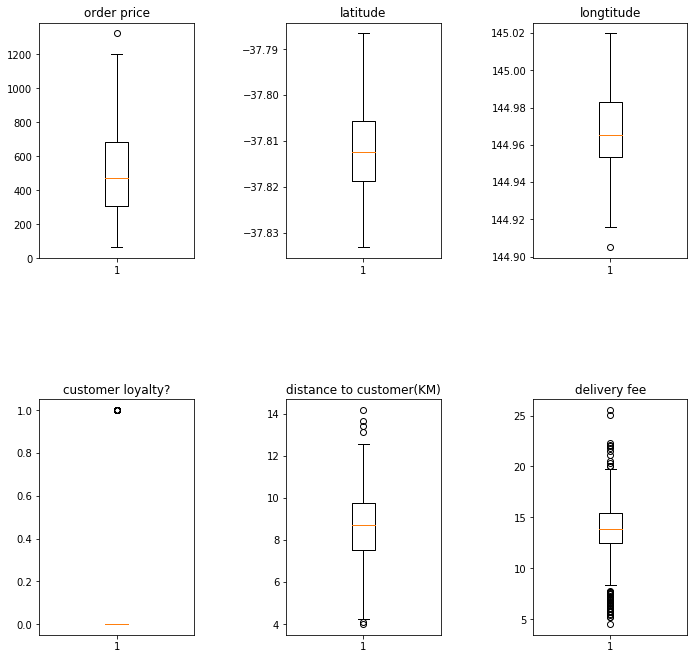

In [73]:
#set the big fiure
fig, axs = plt.subplots(2, 3, figsize =(10,10))

# order price plot
axs[0,0].boxplot(df1.order_price, 0)
axs[0,0].set_title('order price')

# customer latitude plot
axs[0,1].boxplot(df1.customer_lat, 0)
axs[0,1].set_title('latitude')

# customer longtitude plot
axs[0,2].boxplot(df1.customer_lon, 0)
axs[0,2].set_title('longtitude')

# customerHasloyalty? plot
axs[1,0].boxplot(df1['customerHasloyalty?'], 0)
axs[1,0].set_title("customer loyalty?")

# distance to customer(KM) plot
axs[1,1].boxplot(df1.distance_to_customer_KM, 0)
axs[1,1].set_title('distance to customer(KM)')

# delivery fee plot
axs[1,2].boxplot(df1.delivery_fee, 0)
axs[1,2].set_title('delivery fee')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.6, wspace=0.6)

plt.show()

What we notice is that `'distance to customer(KM)'` and `'delivery fee'` has many outliers.

However, `Delivery fee` depends linearly on three of the following factors in different ways for each branch:
- weekend or weekday (1 or 0)
- time of the day (morning 0, afternoon 1, evening 2)
- distance between branch and customer which is the column `'distance to customer(KM)'`

Therefore, we will arrange dataframe according to the condition above by adding two more columns of `'weekend_weekday'` and `'timeofweek'` before plotting again.

In order to add `'weekend_weekday'` column, we need `datetime` module to be able to regcognize the datetime format of the original data.

The functions `date.strptime(format)` is applied to return a string representing the date in noticeable format and `date.weekday()` is used to return the day of the week as an integer, where Monday is 0 and Sunday is 6. 
We represent weekday by integer 0 as the number of day of week is from 0 to 4, while weekend by interger 0 as the number of day of week is 4 or 5.

For the column `'timeofweek'`, as we know Breakfast is in the morning, Lunch is in the afternoon and Dinner is in the evening, we can refer to the column `order_type` rightaway. Then merge those two new column to the dataset.

In [74]:
#recognize date format using date.strptime() and get day of week using date.weekday()
df2= df1['date'].apply(lambda s: pd.Series({'weekend_weekday': datetime.strptime(s,'%Y-%m-%d').weekday()}))
#change value of the column by giving 1 as weekend and 0 as weekday
df2.loc[df2['weekend_weekday'] < 5, 'weekend_weekday'] = 0
df2.loc[df2['weekend_weekday'] >= 5, 'weekend_weekday'] = 1

#add new column named 'timeofweek' by morning as 0, afternoon as 1 and evening as 2
df1['timeofweek'] = '0'
df1.loc[df1['order_type'] == 'Lunch','timeofweek'] = '1'
df1.loc[df1['order_type'] == 'Dinner','timeofweek'] = '2'

#combine these two new column to the dataset
df1 = pd.concat([df1, df2], axis=1) 

### Investigate outliers for "Delivery fee"

Now the data is ready to be explored

Since the Delivery fee is in different way for each branch, we will look at delivery fee by branch using box plot.  

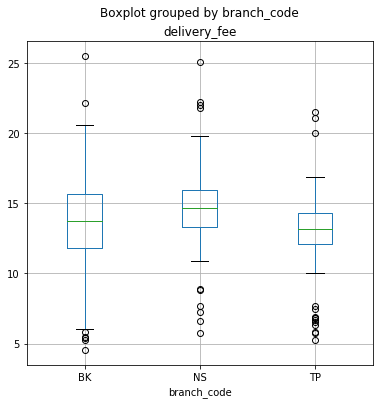

In [75]:
bp = df1.boxplot(column='delivery_fee', by='branch_code', figsize =(6,6))

From the figure above, we can see that the three branches(BK, NS, TP) have many possile outlier so we need further analysis of outlier of each branch in the next section.

## BK branch
We will start by selecting only the data of BK branch, perform the linear fit then detect the outlier.

In [76]:
#select only the BK branch
bk_branch = df1[df1.branch_code == 'BK']
#fit the linear regression
results = sm.ols(formula='delivery_fee ~timeofweek+weekend_weekday+distance_to_customer_KM ', data=bk_branch).fit()
#specify independent variable : timeofweek, weekend_weekday, distance_to_customer_KM
df_x = bk_branch[["timeofweek","weekend_weekday","distance_to_customer_KM"]]
#predict the dependent variable : delivery_fee
Y_ols_pred=results.predict(df_x)
#add column of predicted into the dataframe
bk_branch['predicted delivery_fee']= Y_ols_pred
#calculate residual and add the column
bk_branch['residual']= bk_branch['delivery_fee'] -bk_branch['predicted delivery_fee']

C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Plot the residual using box plot to see the outlier of BK branch.

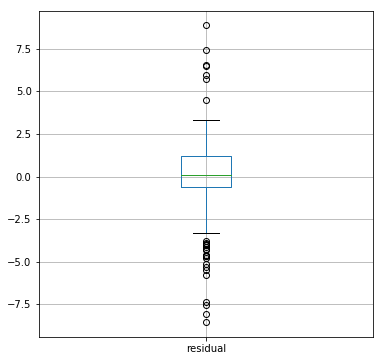

In [77]:
#box plot of BK branch before removing outlier 
bk_before = bk_branch.boxplot(column='residual',figsize =(6,6))

### Outlier detection method: Quartile-based detection and box plot
The detection method that we will use is `Quartile-based detection and box plot` which remove the outlier according to range (Q1 - 1.5*IQR) and (Q3 + 1.5*IQR).

In [78]:
#Calculate Q3, Q1 and IQR
Q3 = np.quantile(bk_branch['residual'],0.75, axis=0)
Q1 = np.quantile(bk_branch['residual'],0.25, axis=0)
IQR = Q3-Q1
#remove the outlier
bk_branch=bk_branch[(bk_branch.residual > (Q1 - 1.5*IQR)) & (bk_branch.residual < (Q3 + 1.5*IQR))]

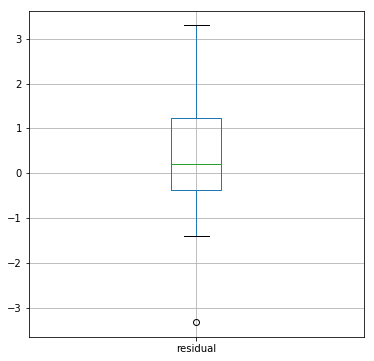

In [79]:
#box plot of BK branch after removing outlier
bk_after = bk_branch.boxplot(column='residual',figsize =(6,6))

You can see that we have removed most of the outlier of the BK branch. Then we will drop unnecessary columns that we include previously.

In [80]:
columns = ['timeofweek','weekend_weekday','predicted delivery_fee','residual']
bk_branch.drop(columns, inplace=True, axis=1)

C:\Users\mio\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [81]:
bk_branch

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
3,ORDA02041,2018-11-17,18:38:52,Dinner,BK,"[('Pasta', 10), ('Salmon', 7)]",562.00,-37.816011,145.005755,0,4.079,13.434910
8,ORDX03999,2018-10-14,17:27:53,Dinner,BK,"[('Pasta', 6), ('Salmon', 5)]",370.00,-37.816481,144.992016,0,5.372,14.786828
11,ORDX09026,2018-05-06,12:03:22,Lunch,BK,"[('Salad', 6), ('Fries', 10), ('Steak', 7), ('...",570.20,-37.822108,144.932693,0,10.840,18.957851
14,ORDA09178,2018-07-19,14:35:29,Lunch,BK,"[('Salad', 4), ('Fries', 5), ('Burger', 3), ('...",445.80,-37.800610,144.973919,0,7.297,13.038727
17,ORDX09730,2018-08-06,15:05:54,Lunch,BK,"[('Steak', 8), ('Chicken', 1), ('Burger', 8)]",640.00,-37.815099,144.969255,0,7.290,12.744473
19,ORDX06360,2018-05-05,12:03:22,Lunch,BK,"[('Burger', 7), ('Salad', 6), ('Steak', 3), ('...",723.20,-37.813920,144.948138,0,9.616,17.614078
20,ORDX07457,2018-12-05,19:09:17,Dinner,BK,"[('Salmon', 9), ('Shrimp', 8)]",801.00,-37.818734,144.955351,0,8.576,15.540686
24,ORDK04595,2018-05-27,12:43:56,Lunch,BK,"[('Fries', 5), ('Burger', 10), ('Salad', 7), (...",746.40,-37.814096,144.993524,0,5.088,13.142316
25,ORDK08855,2018-12-06,19:19:26,Dinner,BK,"[('Salmon', 4), ('Pasta', 7), ('Shrimp', 3), (...",623.50,-37.811010,145.015946,0,4.343,10.732768
26,ORDK07574,2018-08-20,15:36:20,Lunch,BK,"[('Steak', 1), ('Fries', 1), ('Chicken', 1), (...",151.00,-37.804508,144.955773,0,8.234,13.879976


After this we will do the same for the other two branches (NS and TP)

## NS branch

In [82]:
#select only the NS branch
ns_branch = df1[df1.branch_code == 'NS']
#fit the linear regression
results = sm.ols(formula='delivery_fee ~timeofweek+weekend_weekday+distance_to_customer_KM ', data=ns_branch).fit()
#specify independent variable : timeofweek, weekend_weekday, distance_to_customer_KM
df_x = ns_branch[["timeofweek","weekend_weekday","distance_to_customer_KM"]]
#predict the dependent variable : delivery_fee
Y_ols_pred=results.predict(df_x)
#add column of predicted into the dataframe
ns_branch['predicted delivery_fee']= Y_ols_pred
bk_branch['predicted delivery_fee']= Y_ols_pred
#calculate residual and add the column
ns_branch['residual']= ns_branch['delivery_fee'] -ns_branch['predicted delivery_fee']

C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Plot the residual using box plot to see the outlier of NS branch.

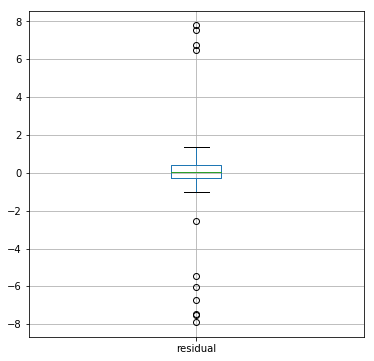

In [83]:
#box plot of NS branch before removing outlier 
ns_before = ns_branch.boxplot(column='residual',figsize =(6,6))

In [84]:
#Calculate Q3, Q1 and IQR
Q3 = np.quantile(ns_branch['residual'],0.75, axis=0)
Q1 = np.quantile(ns_branch['residual'],0.25, axis=0)
IQR = Q3-Q1
#remove the outlier
ns_branch=ns_branch[(ns_branch.residual > (Q1 - 1.5*IQR)) & (ns_branch.residual < (Q3 + 1.5*IQR))]

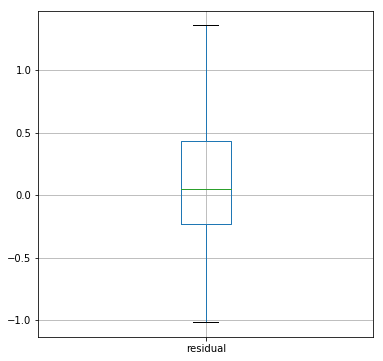

In [85]:
#box plot of NS branch after removing outlier 
ns_after = ns_branch.boxplot(column='residual',figsize =(6,6))

You can see that we have removed most of the outlier of the NS branch. Then we will drop unnecessary columns that we include previously.

In [86]:
columns = ['timeofweek','weekend_weekday','predicted delivery_fee','residual']
ns_branch.drop(columns, inplace=True, axis=1)

C:\Users\mio\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## TP branch

In [87]:
#select only the TP branch
tp_branch = df1[df1.branch_code == 'TP']
#fit the linear regression
results = sm.ols(formula='delivery_fee ~timeofweek+weekend_weekday+distance_to_customer_KM ', data=tp_branch).fit()
#specify independent variable : timeofweek, weekend_weekday, distance_to_customer_KM
df_x = tp_branch[["timeofweek","weekend_weekday","distance_to_customer_KM"]]
#predict the dependent variable : delivery_fee
Y_ols_pred=results.predict(df_x)
#add column of predicted into the dataframe
tp_branch['predicted delivery_fee']= Y_ols_pred
#calculate residual and add the column
tp_branch['residual']= tp_branch['delivery_fee'] -tp_branch['predicted delivery_fee']

C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Plot the residual using box plot to see the outlier of TP branch.

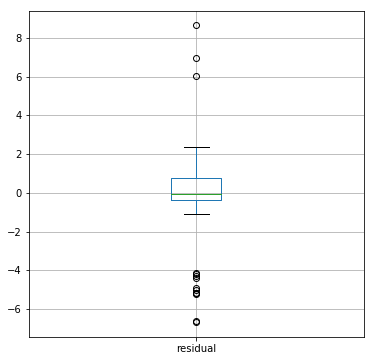

In [88]:
#box plot of NS branch before removing outlier 
tp_before = tp_branch.boxplot(column='residual',figsize =(6,6))

In [89]:
#Calculate Q3, Q1 and IQR
Q3 = np.quantile(tp_branch['residual'],0.75, axis=0)
Q1 = np.quantile(tp_branch['residual'],0.25, axis=0)
IQR = Q3-Q1
#remove the outlier
tp_branch=tp_branch[(tp_branch.residual > (Q1 - 1.5*IQR)) & (tp_branch.residual < (Q3 + 1.5*IQR))]

Plot the residual using box plot to see the outlier of NS branch.

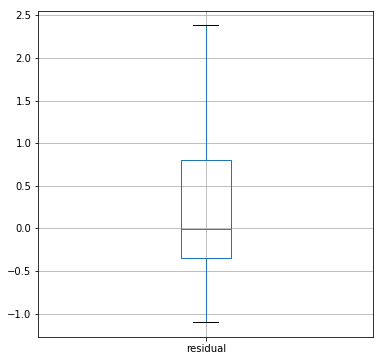

In [90]:
#box plot of TP branch after removing outlier 
tp_after = tp_branch.boxplot(column='residual',figsize =(6,6))

You can see that we have removed most of the outlier of the NS branch. Then we will drop unnecessary columns that we include previously.

In [91]:
columns = ['timeofweek','weekend_weekday','predicted delivery_fee','residual']
tp_branch.drop(columns, inplace=True, axis=1)

C:\Users\mio\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Now we can combine all branch and outout as the `Group148_outlier_data_solution.csv` file

In [92]:
df_row = pd.concat([bk_branch, ns_branch, tp_branch],ignore_index=False)
df_row = df_row[['order_id', 'date', 'time', 'order_type','branch_code', 'order_items','order_price','customer_lat', 'customer_lon','customerHasloyalty?','distance_to_customer_KM','delivery_fee']]

C:\Users\mio\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [93]:
df_row.to_csv('Group148_outlier_data_solution.csv',index=False)

# References

Linear Regression in R -Retrieved 30 September 2019, from 
https://www.datacamp.com/community/tutorials/linear-regression-R

Graph Optimization with NetworkX in Python- Retrieved 30 September 2019, from 
https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

5 Ways to Detect Outliers/Anomalies That Every Data Scientist Should Know (Python Code). (2019). Retrieved 7 October 2019, from https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623